In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import textwrap

In [2]:
csv = """email_id,customer_id,subject,body,tag
1,CUST_A,"Unable to access shared mailbox","Hi team, I'm unable to access the shared mailbox for our support team. It keeps showing a permissions error. Can you please check?","access_issue"
2,CUST_A,"Rules not working","We created a rule to auto-assign emails based on subject line but it stopped working since yesterday.","workflow_issue"
3,CUST_A,"Email stuck in pending","One of our emails is stuck in pending even after marking it resolved. Not sure what’s happening.","status_bug"
4,CUST_B,"Automation creating duplicate tasks","Your automation engine is creating 2 tasks for every email. This started after we edited our workflow.","automation_bug"
5,CUST_B,"Tags missing","Many of our tags are not appearing for new emails. Looks like the tagging model is not working for us.","tagging_issue"
6,CUST_B,"Billing query","We were charged incorrectly this month. Need a corrected invoice.","billing"
7,CUST_C,"CSAT not visible","CSAT scores disappeared from our dashboard today. Is there an outage?","analytics_issue"
8,CUST_C,"Delay in email loading","Opening a conversation takes 8-10 seconds. This is affecting our productivity.","performance"
9,CUST_C,"Need help setting up SLAs","We want to configure SLAs for different customer tiers. Can someone guide us?","setup_help"
10,CUST_D,"Mail merge failing","Mail merge is not sending emails even though the CSV is correct.","mail_merge_issue"
11,CUST_D,"Can't add new user","Trying to add a new team member but getting an 'authorization required' error.","user_management"
12,CUST_D,"Feature request: Dark mode","Dark mode would help during late-night support hours. Please consider this.","feature_request"
"""

In [3]:
from io import StringIO
df = pd.read_csv(StringIO(csv))
df['text'] = (df['subject'].fillna('') + ' ' + df['body'].fillna('')).str.replace('\n',' ', regex=False)
display(df[['email_id','customer_id','subject','tag']])


,email_id,customer_id,subject,tag
0,1,CUST_A,Unable to access shared mailbox,access_issue
1,2,CUST_A,Rules not working,workflow_issue
2,3,CUST_A,Email stuck in pending,status_bug
3,4,CUST_B,Automation creating duplicate tasks,automation_bug
4,5,CUST_B,Tags missing,tagging_issue
5,6,CUST_B,Billing query,billing
6,7,CUST_C,CSAT not visible,analytics_issue
7,8,CUST_C,Delay in email loading,performance
8,9,CUST_C,Need help setting up SLAs,setup_help
9,10,CUST_D,Mail merge failing,mail_merge_issue


In [4]:
customer_labels = df.groupby('customer_id')['tag'].unique().to_dict()
print("Customer -> labels:")
for c,l in customer_labels.items():
    print(c, ":", list(l))

Customer -> labels:
CUST_A : ['access_issue', 'workflow_issue', 'status_bug']
CUST_B : ['automation_bug', 'tagging_issue', 'billing']
CUST_C : ['analytics_issue', 'performance', 'setup_help']
CUST_D : ['mail_merge_issue', 'user_management', 'feature_request']


In [5]:
def train_per_customer_models(df, min_examples): #removed 2
    """Train a TF-IDF + LogisticRegression for each customer with enough examples."""
    models = {}
    vectorizers = {}
    for customer, group in df.groupby('customer_id'):
        if len(group) < min_examples:
            # Skip training per-customer model if too few examples
            continue
        X = group['text'].values
        y = group['tag'].values
        # print ("x: "+X)
        # print ("y: "+y)
        # print ("customer: "+customer)
        # print ("group: " )
        # print("***********")
        vec = TfidfVectorizer(ngram_range=(1,2), max_features=2000)
        Xv = vec.fit_transform(X)
        clf = LogisticRegression(max_iter=1000)
        clf.fit(Xv, y)
        models[customer] = clf
        vectorizers[customer] = vec
    return models, vectorizers

def train_global_model(df):
    vec = TfidfVectorizer(ngram_range=(1,2), max_features=3000)
    Xv = vec.fit_transform(df['text'].values)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(Xv, df['tag'].values)
    return clf, vec

# Train
per_models, per_vecs = train_per_customer_models(df, min_examples=3)  # none will train with min_examples=3 for small set
global_clf, global_vec = train_global_model(df)

In [6]:
customer_to_labels = {k:set(v) for k,v in customer_labels.items()}


In [7]:
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))


In [8]:
def predict_with_customer_filter(texts, customer_id, clf=global_clf, vec=global_vec, label_set=None):
    """Predict using global model but restrict labels to customer's label set."""
    Xv = vec.transform(texts)
    probs = clf.predict_proba(Xv)
    labels = clf.classes_
    results = []
    allowed = label_set if label_set is not None else customer_to_labels.get(customer_id, set(labels))
    # map label -> index
    label_idx = {lab:i for i,lab in enumerate(labels)}
    for i in range(len(texts)):
        # filter probs to allowed labels
        filtered = {lab: (probs[i][label_idx[lab]] if lab in label_idx else 0.0) for lab in allowed}
        # Choose top
        pred_label = max(filtered.items(), key=lambda x: x[1])[0]
        pred_conf = filtered[pred_label]
        results.append({'pred':pred_label, 'conf':pred_conf, 'probs_filtered':filtered})
    return results

In [9]:
demo_texts = df['text'].tolist()
preds = predict_with_customer_filter(demo_texts, customer_id=None)  # None => use label set per row
#print(preds)
# show first three
for i,p in enumerate(preds[:5]):
    print(i+1, "=>", p)

1 => {'pred': 'access_issue', 'conf': 0.17839309367977255, 'probs_filtered': {'access_issue': 0.17839309367977255, 'user_management': 0.07834739626584489, 'billing': 0.07357665933183419, 'performance': 0.07361510442783853, 'automation_bug': 0.07396528890771999, 'setup_help': 0.07578676431864981, 'tagging_issue': 0.0743491294546104, 'status_bug': 0.07373733166875676, 'workflow_issue': 0.07489034498059606, 'feature_request': 0.07568073709180255, 'analytics_issue': 0.07380636408419064, 'mail_merge_issue': 0.07385178578838379}}
2 => {'pred': 'workflow_issue', 'conf': 0.17844760104562304, 'probs_filtered': {'access_issue': 0.0748898214426128, 'user_management': 0.07537131774633787, 'billing': 0.07466208969023999, 'performance': 0.07311946890917936, 'automation_bug': 0.0737539335848528, 'setup_help': 0.07476859122781641, 'tagging_issue': 0.07773569864738024, 'status_bug': 0.07484805676379834, 'workflow_issue': 0.17844760104562304, 'feature_request': 0.07375301038444483, 'analytics_issue': 0.

In [10]:
PATTERN_RULES = [
    # (pattern_type, keywords, target_tag, explanation)
    ('must_have', ['billing', 'invoice', 'charged', 'refund'], 'billing', "Billing keywords -> billing"),
    ('must_have', ['csat', 'survey', 'CSAT'], 'analytics_issue', "CSAT keywords -> analytics_issue"),
    ('must_have', ['dark mode', 'darkmode', 'dark-mode'], 'feature_request', "Feature request for dark mode"),
    ('avoid', ['rule', 'rules', 'workflow'], 'workflow_issue', "workflow-related"),
]

In [11]:
def rule_engine(text, customer_id):
    text_l = text.lower()
    overrides = []
    for rule in PATTERN_RULES:
        typ, keywords, target_tag, explanation = rule
        for kw in keywords:
            if kw.lower() in text_l:
                if typ == 'must_have':
                    overrides.append((target_tag, explanation))
                elif typ == 'avoid':
                    # an avoid rule might just be a signal; we return it for use
                    overrides.append((None, explanation + f" (seen {kw})"))
    return overrides

In [12]:
df

,email_id,customer_id,subject,body,tag,text
0,1,CUST_A,Unable to access shared mailbox,"Hi team, I'm unable to access the shared mailb...",access_issue,"Unable to access shared mailbox Hi team, I'm u..."
1,2,CUST_A,Rules not working,We created a rule to auto-assign emails based ...,workflow_issue,Rules not working We created a rule to auto-as...
2,3,CUST_A,Email stuck in pending,One of our emails is stuck in pending even aft...,status_bug,Email stuck in pending One of our emails is st...
3,4,CUST_B,Automation creating duplicate tasks,Your automation engine is creating 2 tasks for...,automation_bug,Automation creating duplicate tasks Your autom...
4,5,CUST_B,Tags missing,Many of our tags are not appearing for new ema...,tagging_issue,Tags missing Many of our tags are not appearin...
5,6,CUST_B,Billing query,We were charged incorrectly this month. Need a...,billing,Billing query We were charged incorrectly this...
6,7,CUST_C,CSAT not visible,CSAT scores disappeared from our dashboard tod...,analytics_issue,CSAT not visible CSAT scores disappeared from ...
7,8,CUST_C,Delay in email loading,Opening a conversation takes 8-10 seconds. Thi...,performance,Delay in email loading Opening a conversation ...
8,9,CUST_C,Need help setting up SLAs,We want to configure SLAs for different custom...,setup_help,Need help setting up SLAs We want to configure...
9,10,CUST_D,Mail merge failing,Mail merge is not sending emails even though t...,mail_merge_issue,Mail merge failing Mail merge is not sending e...


In [13]:
for i,row in df.iterrows():
    rules = rule_engine(row['text'], row['customer_id'])
    if rules:
        print("id", row['email_id'], "rules:", rules)

id 2 rules: [(None, 'workflow-related (seen rule)'), (None, 'workflow-related (seen rules)')]
id 4 rules: [(None, 'workflow-related (seen workflow)')]
id 6 rules: [('billing', 'Billing keywords -> billing'), ('billing', 'Billing keywords -> billing'), ('billing', 'Billing keywords -> billing')]
id 7 rules: [('analytics_issue', 'CSAT keywords -> analytics_issue'), ('analytics_issue', 'CSAT keywords -> analytics_issue')]
id 12 rules: [('feature_request', 'Feature request for dark mode')]


In [14]:
def predict_pipeline(row, per_models, per_vecs, global_clf, global_vec, customer_to_labels, conf_threshold=0.6):
    text = row['text']
    cust = row['customer_id']
    # 1) rule engine (strong rules)
    rules = rule_engine(text, cust)
    # If a must_have rule matches strongly, use override
    for r in rules:
        target, explain = r
        if target is not None:
            return {'pred': target, 'conf': 0.99, 'reason': f'rule_override: {explain}'}
    # 2) per-customer model if available
    if cust in per_models:
        vec = per_vecs[cust]
        clf = per_models[cust]
        Xv = vec.transform([text])
        probs = clf.predict_proba(Xv)[0]
        labels = clf.classes_
        best_idx = np.argmax(probs)
        return {'pred': labels[best_idx], 'conf': float(probs[best_idx]), 'reason': 'per_customer_model'}
    # 3) global model with dynamic label filtering
    allowed = customer_to_labels.get(cust, set(global_clf.classes_))
    res = predict_with_customer_filter([text], cust, clf=global_clf, vec=global_vec, label_set=allowed)[0]
    # 4) anti-pattern: if confidence low but "avoid" rule present, flag for review
    if res['conf'] < conf_threshold:
        # check avoid rules
        for r in rules:
            if r[0] is None:  # avoid rule
                return {'pred': res['pred'], 'conf': res['conf'], 'reason': 'low_conf_and_anti_pattern:' + r[1]}
    return {'pred': res['pred'], 'conf': res['conf'], 'reason': 'global_filtered'}


In [15]:
pred_rows = []
for i,row in df.iterrows():
    p = predict_pipeline(row, per_models, per_vecs, global_clf, global_vec, customer_to_labels)
    pred_rows.append({**row.to_dict(), **p})
pred_df = pd.DataFrame(pred_rows)
display(pred_df[['email_id','customer_id','tag','pred','conf','reason']])

,email_id,customer_id,tag,pred,conf,reason
0,1,CUST_A,access_issue,access_issue,0.507608,per_customer_model
1,2,CUST_A,workflow_issue,workflow_issue,0.505673,per_customer_model
2,3,CUST_A,status_bug,status_bug,0.507095,per_customer_model
3,4,CUST_B,automation_bug,automation_bug,0.502757,per_customer_model
4,5,CUST_B,tagging_issue,tagging_issue,0.507195,per_customer_model
5,6,CUST_B,billing,billing,0.990000,rule_override: Billing keywords -> billing
6,7,CUST_C,analytics_issue,analytics_issue,0.990000,rule_override: CSAT keywords -> analytics_issue
7,8,CUST_C,performance,performance,0.506776,per_customer_model
8,9,CUST_C,setup_help,setup_help,0.511584,per_customer_model
9,10,CUST_D,mail_merge_issue,mail_merge_issue,0.510406,per_customer_model



Classification report (global filtered predictions):
                  precision    recall  f1-score   support

    access_issue       1.00      1.00      1.00         1
 analytics_issue       1.00      1.00      1.00         1
  automation_bug       1.00      1.00      1.00         1
         billing       1.00      1.00      1.00         1
 feature_request       1.00      1.00      1.00         1
mail_merge_issue       1.00      1.00      1.00         1
     performance       1.00      1.00      1.00         1
      setup_help       1.00      1.00      1.00         1
      status_bug       1.00      1.00      1.00         1
   tagging_issue       1.00      1.00      1.00         1
 user_management       1.00      1.00      1.00         1
  workflow_issue       1.00      1.00      1.00         1

        accuracy                           1.00        12
       macro avg       1.00      1.00      1.00        12
    weighted avg       1.00      1.00      1.00        12



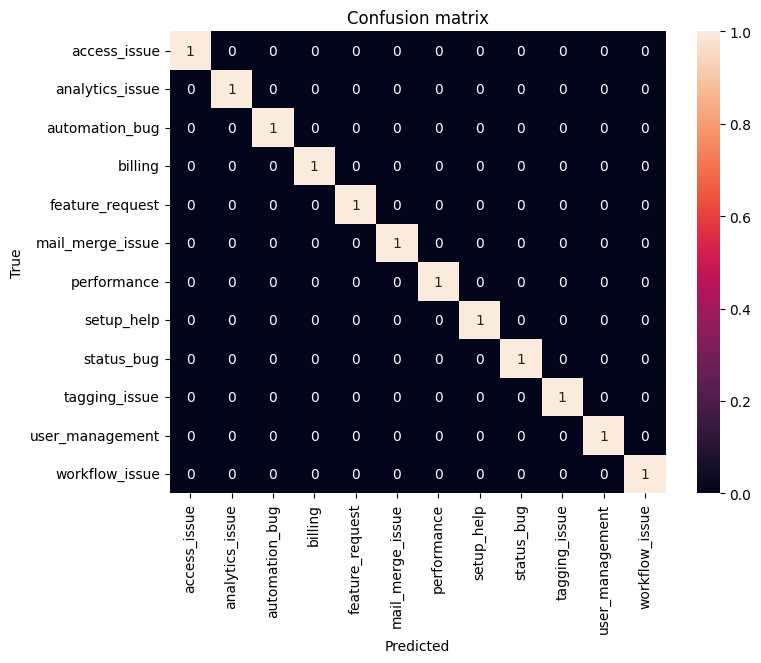

In [16]:
print("\nClassification report (global filtered predictions):")
print(classification_report(pred_df['tag'], pred_df['pred'], zero_division=0))

# Confusion matrix
cm = confusion_matrix(pred_df['tag'], pred_df['pred'], labels=global_clf.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=global_clf.classes_, yticklabels=global_clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

In [17]:
def top_terms_for_label(vec, clf, label, topn=8):
    if label not in clf.classes_:
        return []
    idx = list(clf.classes_).index(label)
    # logistic regression coef_ shape (n_classes, n_features) for 'ovr' multi_class
    if hasattr(clf, 'coef_'):
        coefs = clf.coef_
        # find feature names
        feat = vec.get_feature_names_out()
        # For ovR classifier scikit sets coef_ per class
        class_coefs = coefs[idx]
        top_pos = np.argsort(class_coefs)[-topn:][::-1]
        return [(feat[i], float(class_coefs[i])) for i in top_pos]
    return []

In [18]:
for lab in global_clf.classes_:
    terms = top_terms_for_label(global_vec, global_clf, lab, topn=6)
    print(f"Label: {lab} -> Top terms: {terms}")


Label: access_issue -> Top terms: [('to access', 0.20779955061989772), ('unable to', 0.20779955061989772), ('shared mailbox', 0.20779955061989772), ('shared', 0.20779955061989772), ('access', 0.20779955061989772), ('mailbox', 0.20779955061989772)]
Label: analytics_issue -> Top terms: [('csat', 0.3170272258227317), ('an outage', 0.15851361291136584), ('our dashboard', 0.15851361291136584), ('outage', 0.15851361291136584), ('is there', 0.15851361291136584), ('today is', 0.15851361291136584)]
Label: automation_bug -> Top terms: [('automation', 0.2554651456251459), ('creating', 0.2554651456251459), ('tasks', 0.2554651456251459), ('your automation', 0.12773257281257294), ('your', 0.12773257281257294), ('engine is', 0.12773257281257294)]
Label: billing -> Top terms: [('were charged', 0.18465425570752214), ('this month', 0.18465425570752214), ('we were', 0.18465425570752214), ('were', 0.18465425570752214), ('month', 0.18465425570752214), ('billing', 0.18465425570752214)]
Label: feature_reques

In [19]:
mis = pred_df[pred_df['tag'] != pred_df['pred']].copy()
print("Misclassifications:")
display(mis[['email_id','customer_id','text','tag','pred','conf','reason']])

Misclassifications:


,email_id,customer_id,text,tag,pred,conf,reason


In [20]:
def analyze_mis(row):
    text = row['text'].lower()
    suggestions = []
    # simple heuristics for why it failed
    if any(k in text for k in ['billing','invoice','charged']):
        suggestions.append("Maybe billing keywords present — ensure billing is prioritized in pattern rules.")
    if 'csat' in text or 'survey' in text:
        suggestions.append("CSAT mention — force analytics document retrieval or add more CSAT examples.")
    if 'dark mode' in text:
        suggestions.append("Feature request; add more feature_request examples for this customer.")
    if not suggestions:
        suggestions.append("Collect more labeled examples for this customer/tag.")
    return suggestions

if not mis.empty:
    for idx,row in mis.iterrows():
        print(f"Email {row['email_id']} ({row['customer_id']}): true={row['tag']} pred={row['pred']} conf={row['conf']:.2f}")
        for s in analyze_mis(row):
            print(" -", s)
        print()


In [22]:
# TEST CELL
sample_text = "We cannot access the shared mailbox. Permission denied."
sample_customer = "CUST_A"

pred = predict_pipeline(
    {"text": sample_text, "customer_id": sample_customer},
    per_models, per_vecs, global_clf, global_vec, customer_to_labels
)

print(pred)


{'pred': 'access_issue', 'conf': 0.4110055117585131, 'reason': 'per_customer_model'}


In [23]:
#TEST FUNCTION 
def test_model():
    tests = [
        ("billing issue, wrong charge", "CUST_B"),
        ("csat not visible on dashboard", "CUST_C"),
        ("unable to access mailbox", "CUST_A"),
        ("dark mode request", "CUST_D"),
    ]
    
    for text, cust in tests:
        result = predict_pipeline(
            {"text": text, "customer_id": cust},
            per_models, per_vecs, global_clf, global_vec, customer_to_labels
        )
        print(f"Customer: {cust} | Text: {text} → Prediction: {result['pred']} (conf: {result['conf']:.2f})")
test_model()

Customer: CUST_B | Text: billing issue, wrong charge → Prediction: billing (conf: 0.99)
Customer: CUST_C | Text: csat not visible on dashboard → Prediction: analytics_issue (conf: 0.99)
Customer: CUST_A | Text: unable to access mailbox → Prediction: access_issue (conf: 0.43)
Customer: CUST_D | Text: dark mode request → Prediction: feature_request (conf: 0.99)


In [24]:
#Test using full dataset 
df["test_pred"] = df.apply(
    lambda row: predict_pipeline(
        row, per_models, per_vecs, global_clf, global_vec, customer_to_labels
    )["pred"],
    axis=1
)

print(df[["email_id","customer_id","tag","test_pred"]])


    email_id customer_id               tag         test_pred
0          1      CUST_A      access_issue      access_issue
1          2      CUST_A    workflow_issue    workflow_issue
2          3      CUST_A        status_bug        status_bug
3          4      CUST_B    automation_bug    automation_bug
4          5      CUST_B     tagging_issue     tagging_issue
5          6      CUST_B           billing           billing
6          7      CUST_C   analytics_issue   analytics_issue
7          8      CUST_C       performance       performance
8          9      CUST_C        setup_help        setup_help
9         10      CUST_D  mail_merge_issue  mail_merge_issue
10        11      CUST_D   user_management   user_management
11        12      CUST_D   feature_request   feature_request


In [25]:
#Test for customer isolation 
def check_customer_isolation():
    leaks = []
    for _, row in df.iterrows():
        allowed = customer_labels[row["customer_id"]]
        pred = predict_pipeline(row, per_models, per_vecs, global_clf, global_vec, customer_to_labels)["pred"]
        if pred not in allowed:
            leaks.append((row["email_id"], row["customer_id"], pred))
    return leaks

check_customer_isolation()


[]

In [ ]:
#It is empty → NO TAG LEAKAGE → so it is perfect